# Task 2. Open-vocabulary segmentation

In this notebook, we evaluate a segmentation model by calculating the **mean Intersection over Union (IoU)** for various **clip score thresholds** across different prompt types. The goal is to understand how prompt specificity and clip score thresholds impact the model's performance.

### Key Objectives:
1. **Evaluate Prompt Impact:**
   - Compare how different prompts affect segmentation accuracy.
   - Prompts tested include: 
     - "a photo of a chair"
     - "chair"
     - "A simple office chair."
     - "A chair placed near a desk."
   
2. **Analyze Threshold Impact:**
   - Assess performance using varying clip score thresholds to determine the optimal threshold for each prompt.
   
3. **Quantitative Evaluation:**
   - Calculate the **mean IoU** for each prompt at different thresholds and visualize the results.

By understanding how prompt specificity and thresholds influence model behavior, we aim to find the optimal configuration for reliable object segmentation.


Author: **Grozny Sergey**

In [295]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os
from PIL import Image
from torch.utils.data import Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import matplotlib

In [292]:
class SemanticDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        """
        Args:
            images_dir (str): Path to the directory containing images.
            masks_dir (str): Path to the directory containing .npy masks.
            transform (callable, optional): Transform to apply to the images.
            mask_transform (callable, optional): Transform to apply to the masks.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform
        
        # Gather the list of image files
        self.image_filenames = sorted([
            f for f in os.listdir(images_dir) 
            if f.endswith('.JPG')
        ])
        
        # Ensure corresponding masks exist
        self.mask_filenames = sorted([
            f for f in os.listdir(masks_dir) 
            if f.endswith('.npy')
        ])
        assert len(self.image_filenames) == len(self.mask_filenames), (
            "Number of images and masks do not match!"
        )
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        #image = Image.open(img_path).convert('RGB')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Load mask
        
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])
        mask = np.load(mask_path)
        #mask = torch.tensor(mask, dtype=torch.float32)
        
        return image, mask


In [293]:
images_dir = "images_0a7cc"
masks_dir = "gt_semantic_2d/render_semantic_npy"
dataset = SemanticDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
)

In [294]:
id2class = pd.read_csv('semantic_classes.txt', header=None, names=['class'])['class'].to_dict()

In [296]:
def draw_mask(mask, id2class, colormap=None):
    # Generate random colors for each class if colormap is not provided
    if colormap is None:
        np.random.seed(42)  # For reproducibility
        unique_classes = list(id2class.keys())
        colormap = {
            class_id: np.random.randint(0, 256, size=3) / 255.0
            for class_id in unique_classes
        }
    
    # Create an RGB image for the mask
    h, w = mask.shape[-2:]
    rgb_mask = np.zeros((h, w, 3), dtype=np.float32)
    
    for class_id, color in colormap.items():
        rgb_mask[mask == class_id] = color
    
    # Plot the mask
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_mask)
    plt.axis("off")

    plt.show()


In [297]:
image, gt_mask = dataset[80]

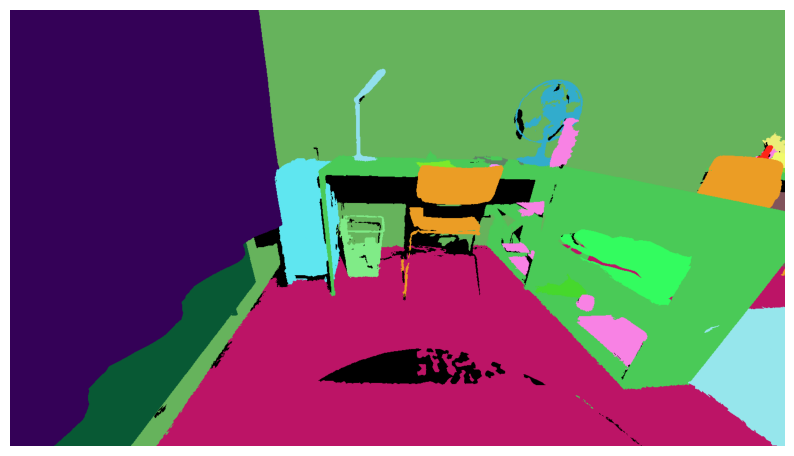

In [299]:
draw_mask(gt_mask, id2class)

In [51]:
sam_checkpoint = "sam_vit_h_4b8939.pth" # https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/br0fire/.pyenv/versions/3.10.15/envs/jupyter/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict =

In [52]:
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# IoU Calculation

The **Intersection over Union (IoU)** is used as the primary metric for evaluating segmentation performance. For each prompt, we calculate the mean IoU at various clip score thresholds.

### IoU Formula:
$$
\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
$$

*Note: if there are no chairs on the scence and model predicts nothing, then we set iou to 1.*


In [316]:
def calculate_iou(pred, true, is_one=True):
    
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
        
    if union == 0:
        if is_one:
            return 1
        else:
            return -1

    iou = intersection / union
    return iou


In [317]:
def get_cropped_and_masks(image, masks):
    cropped_images = []
    segm_masks = []
    for m in masks:
        x, y, w, h = m['bbox']
        cropped_image = image[y:y+h, x:x+w]
        segm_masks.append(m['segmentation'])
        cropped_images.append(cropped_image)
    
    return cropped_images, np.array(segm_masks)

In [318]:
def calculate_css(dataset, clip, processor, mask_generator, prompt="a photo of a chair"):
    css = []
    segm_arr = []
    gt_arr = []
    img_arr = []
    for i in tqdm(range(0, len(dataset), 10)):
        image, gt_mask = dataset[i]
        masks = mask_generator.generate(image)
        cropped_images, segm_masks = get_cropped_and_masks(image, masks)
        inputs = processor(text=[prompt], images=cropped_images, return_tensors='pt')
        inputs.to(device)
        with torch.no_grad():
            outputs = clip(**inputs)
        img_f = outputs.image_embeds
        txt_f = outputs.text_embeds
        clip_scores = (img_f @ txt_f.T).squeeze().cpu().numpy()
        css.append(clip_scores)
        gt_arr.append(gt_mask)
        segm_arr.append(segm_masks)
        img_arr.append(image)
    return css, gt_arr, segm_arr, img_arr

In [319]:
def calculate_mean_iou(css, gt_arr, segm_arr, t, is_one=True):
    iou_arr = []
    for i in range(len(css)):
        cs = css[i]
        gt = gt_arr[i]
        segm = segm_arr[i]
        best_segm = segm[cs > t]
        chair_mask = (gt==8)
        pred_mask = best_segm.any(axis=0)
        iou = calculate_iou(pred_mask, chair_mask, is_one)
        if iou != -1:
            iou_arr.append(iou)
    return np.mean(iou_arr)

In [321]:
def pipeline(dataset, clip, processor, mask_generator, prompt="a photo of a chair", is_one=True):
    css, gt_arr, segm_arr, img_arr = calculate_css(dataset, model, processor, mask_generator, prompt=prompt)
    values = np.hstack(css)
    t_arr = np.linspace(values.min(), values.max(), 100)
    iou_means = []
    for t in tqdm(t_arr):
        iou_mean = calculate_mean_iou(css, gt_arr, segm_arr, t, is_one)
        iou_means.append(iou_mean)
    plt.plot(t_arr, iou_means)
    plt.grid()
    plt.xlabel('threshold')
    plt.ylabel('mean_iou')
    plt.title(f'Prompt:{prompt}')
    plt.show()
    return t_arr[np.argmax(iou_means)], np.max(iou_means)

# Threshold and prompt evaluation

**Clip score threshold**: The clip score is used to filter predictions based on their confidence. By adjusting this threshold, we control the trade-off between precision and recall. A higher threshold might improve precision but at the cost of reducing recall, and vice versa.

### Procedure:
1. For each prompt, segment the images using the model.
2. Calculate the IoU for each prediction.
3. Vary the clip score threshold and compute the mean IoU for each threshold.
4. Visualize the change in mean IoU with respect to different clip score thresholds.

We compare the performance of four different prompts:

- **Prompt 1**: "a photo of a chair"  
- **Prompt 2**: "chair"  
- **Prompt 3**: "A simple office chair."  
- **Prompt 4**: "A chair placed near a desk."

### Why These Prompts?
The prompts vary in terms of specificity, ranging from very general ("chair") to more detailed descriptions ("A chair placed near a desk"). We hypothesize that more detailed prompts will lead to better segmentation accuracy, as the model receives more contextual information.


### Evaluation Metrics:
We calculate **mean IoU** for each prompt at varying clip score thresholds, with the goal of determining which prompt works best for segmentation at different confidence levels.


100%|████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.81it/s]


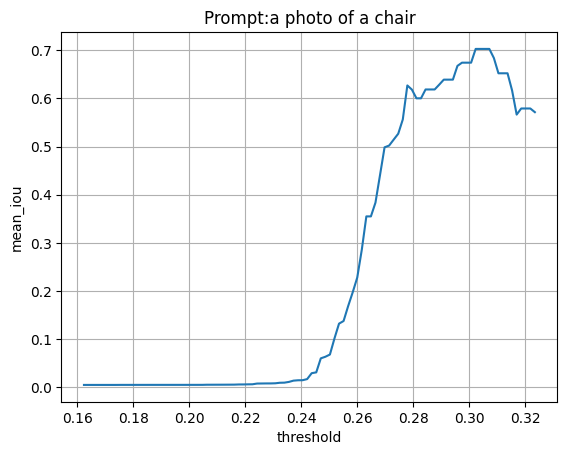

100%|████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]


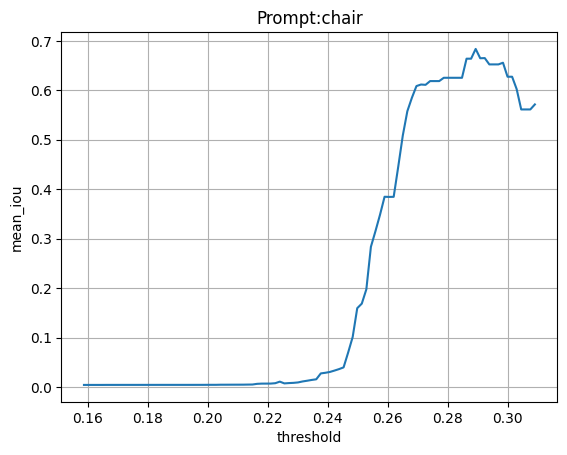

100%|████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]


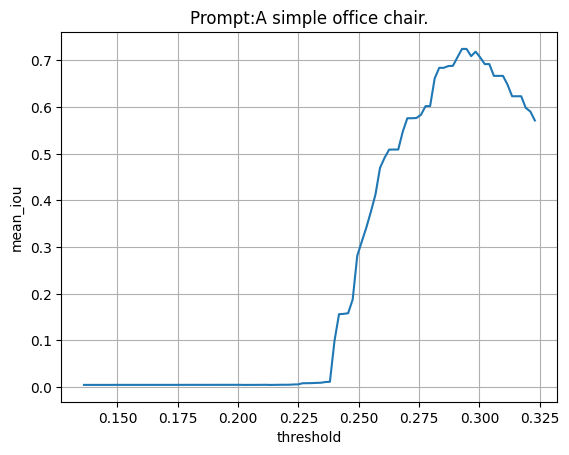

100%|████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]


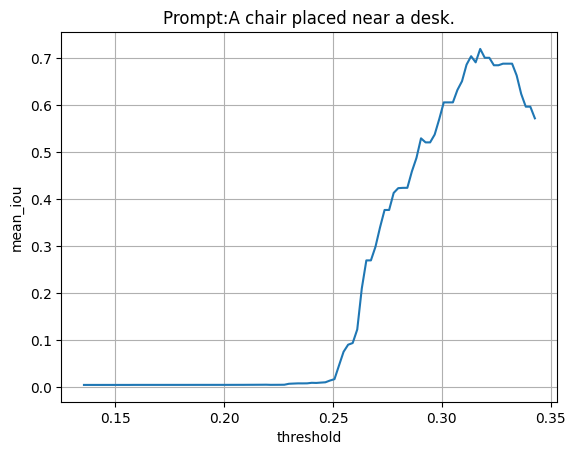

In [305]:
prompts = ["a photo of a chair", "chair", "A simple office chair.", "A chair placed near a desk."]
dct = {}
for p in prompts:
    best_t, best_iou = pipeline(dataset, clip, processor, mask_generator, prompt=p)
    dct[p] = [best_t, best_iou]

In [308]:
pd.DataFrame(dct, index=['best_threshold', 'best_iou'])

a photo of a chair     chair  A simple office chair.  \
best_threshold            0.302371  0.289317                0.292795   
best_iou                  0.702837  0.683574                0.724755   

                A chair placed near a desk.  
best_threshold                     0.317629  
best_iou                           0.718979

### **Results and Visualizations**


#### **Best Performing Prompt: "A simple office chair."**
The prompt "A simple office chair." achieved the highest **mean IoU** of **0.724755**. This result suggests that more detailed prompts with clear descriptions provide better model performance. This specific prompt likely helps the model focus on key attributes of the object (i.e., "office chair") and results in better segmentation accuracy.

#### **Threshold Sensitivity Analysis**
We evaluated the model's performance at different clip score thresholds for each prompt. The results indicate the following trends:

- **Low Thresholds (e.g., 0.15, 0.2):**
  At low thresholds, the model tends to consider more masks as valid predictions, including many low-quality or incorrect ones. As a result, the **mean IoU** is lower because the model produces a significant number of false positives, leading to a lot of bad or incomplete masks. This reduces the overall accuracy of the segmentation.

- **Optimal Thresholds (e.g., 0.29):**
  As the clip score threshold increases, the model becomes more selective, only keeping the high-confidence predictions. This results in fewer but more accurate predictions, leading to a higher **mean IoU**. The **best performance** was achieved at the higher thresholds, where the model filtered out poor masks and focused on more accurate segmentations.

#### **Summary of Key Findings:**
1. **Prompt "A simple office chair."** consistently outperformed the other prompts, with the highest mean IoU of 0.724755, demonstrating that more detailed prompts lead to better segmentation results.
2. **Low clip score thresholds**  introduced many false positives, reducing the model's precision and lowering the IoU score.
3. **Higher clip score thresholds** provided the best results by filtering out bad predictions, leading to a higher mean IoU and more accurate segmentations.

The following plots show segmentation according to best achieved iou:

In [309]:
css, gt_arr, segm_arr, img_arr = calculate_css(dataset, model, processor, mask_generator, prompt="A simple office chair")

100%|██████████████████████████████████████████████████████████████| 35/35 [01:26<00:00,  2.47s/it]


In [331]:
df = pd.DataFrame(dct, index=['best_threshold', 'best_iou'])

In [337]:
a, b = df.to_numpy()[0], df.to_numpy()[1]

In [341]:
t_best = a[np.argmax(b)]
t_best

0.2927945488029056

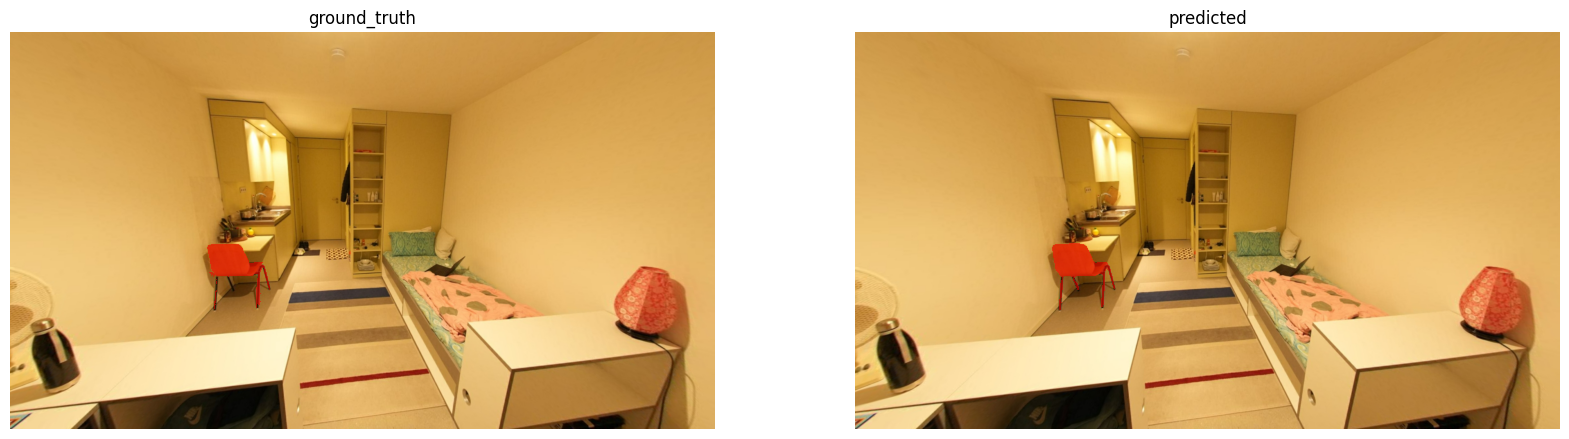

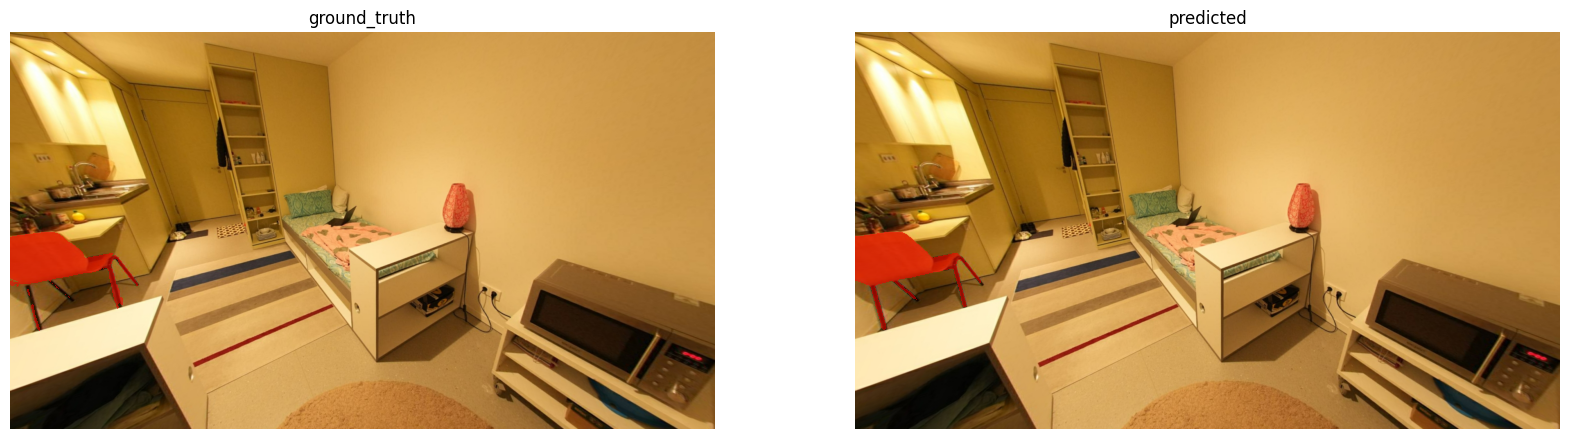

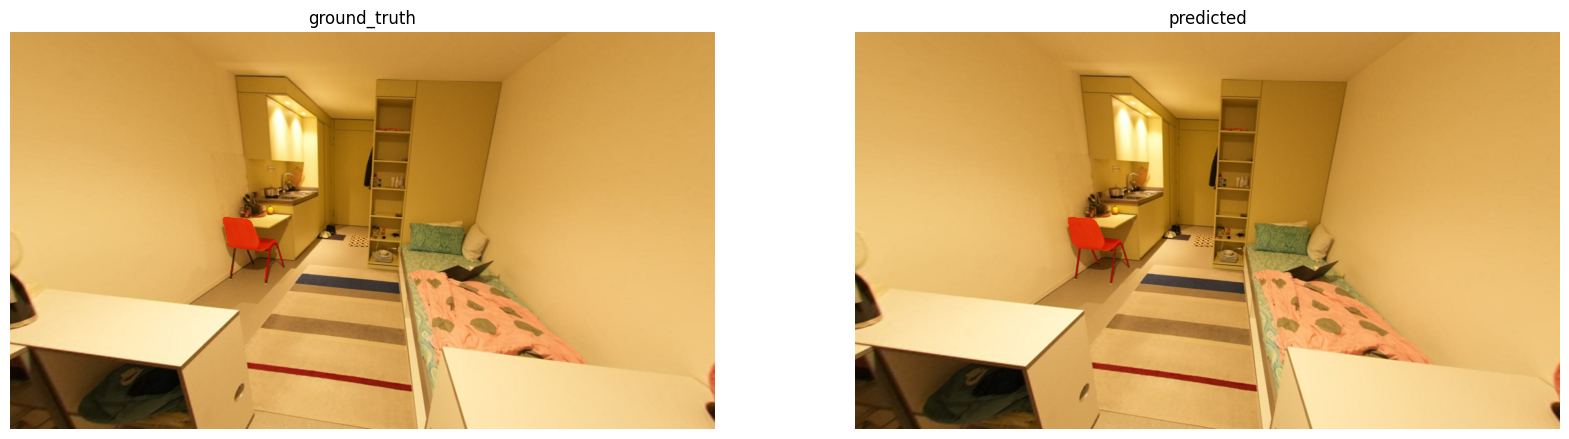

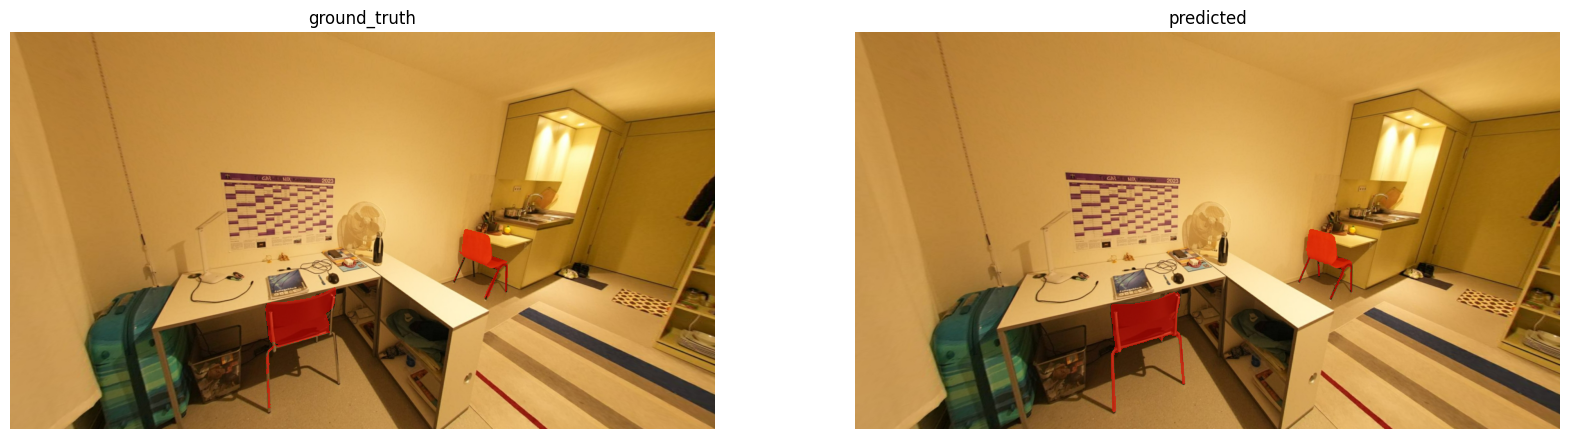

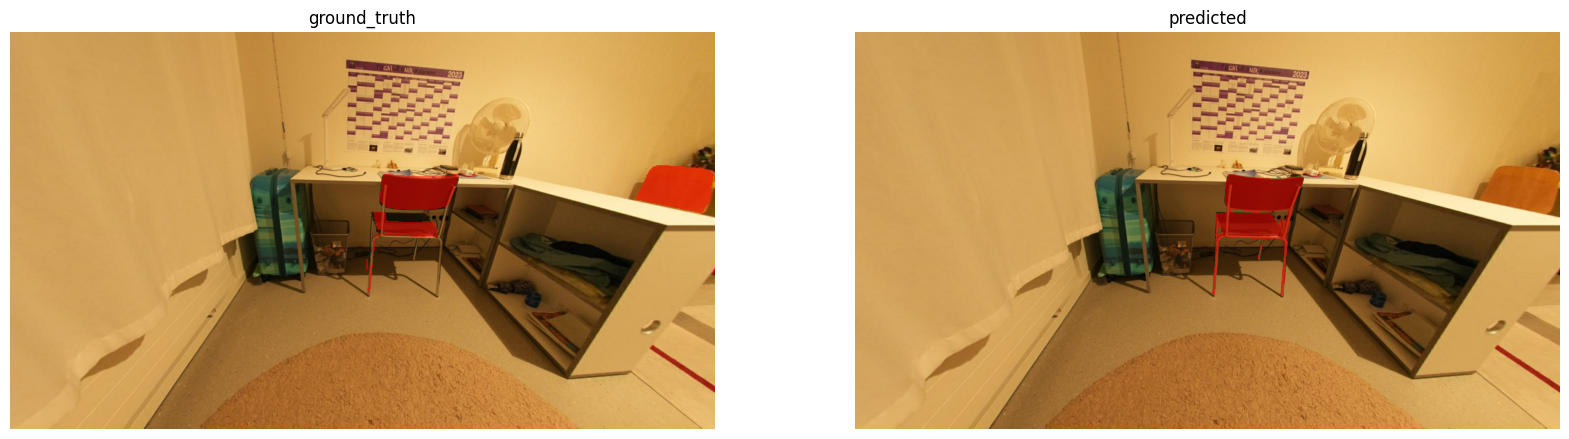

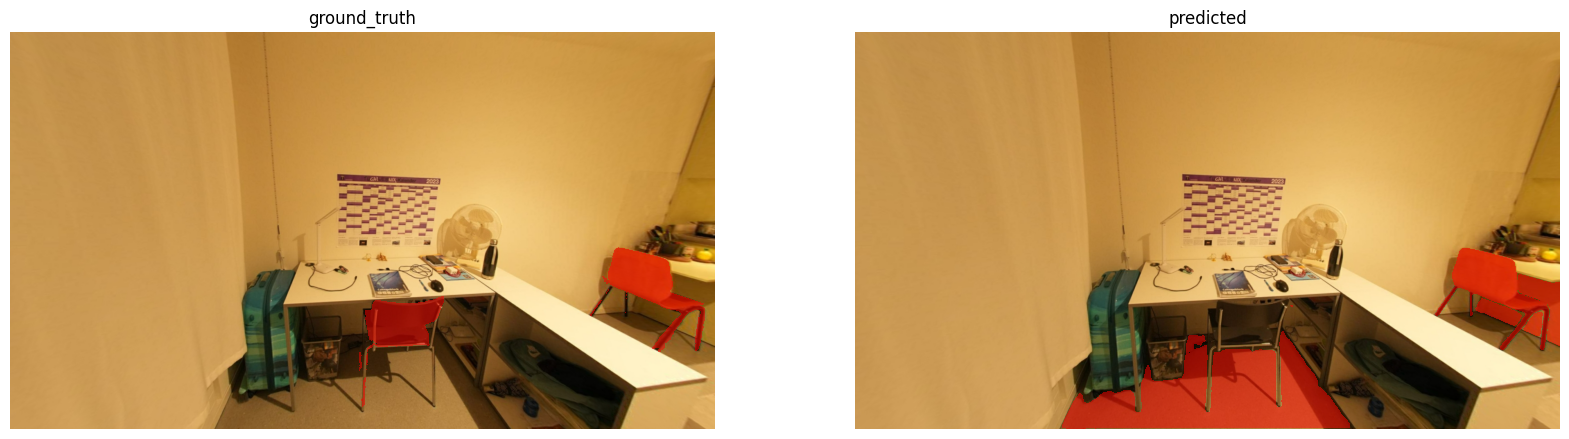

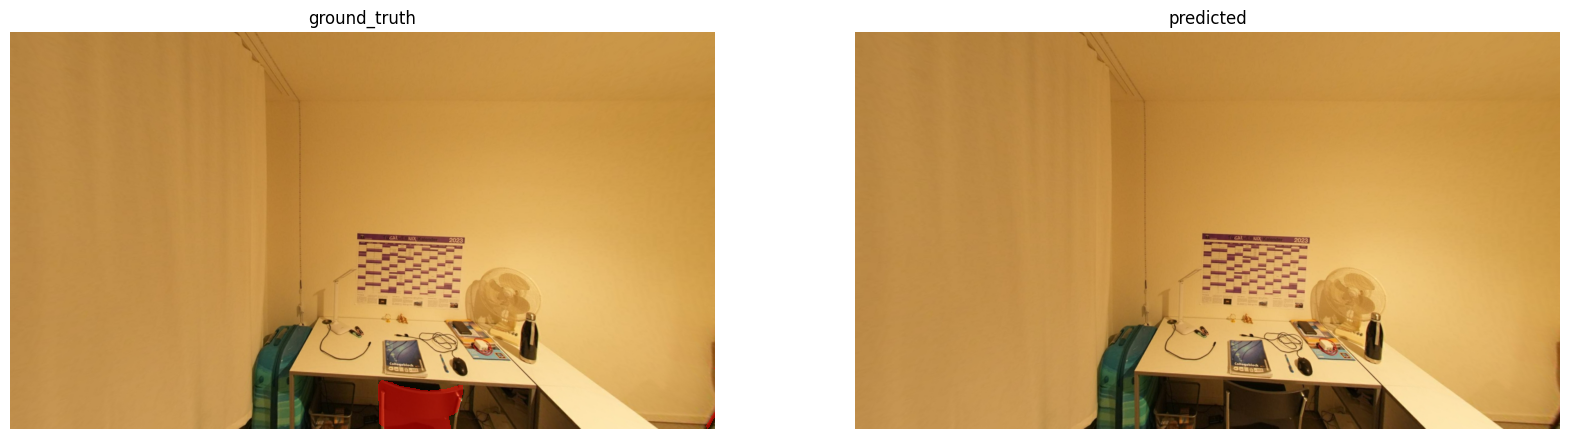

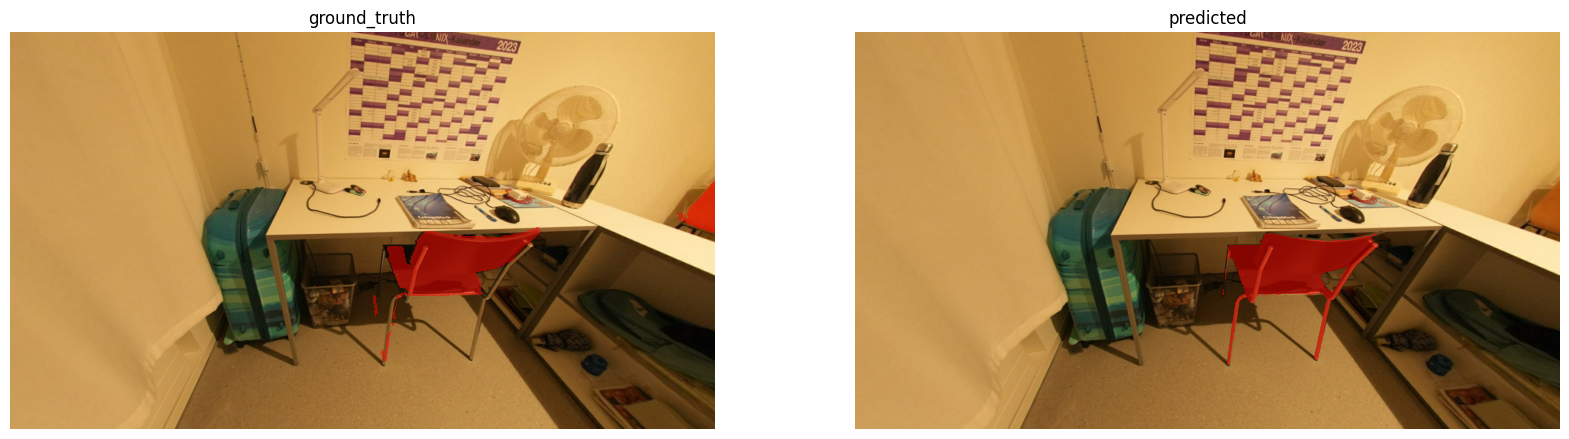

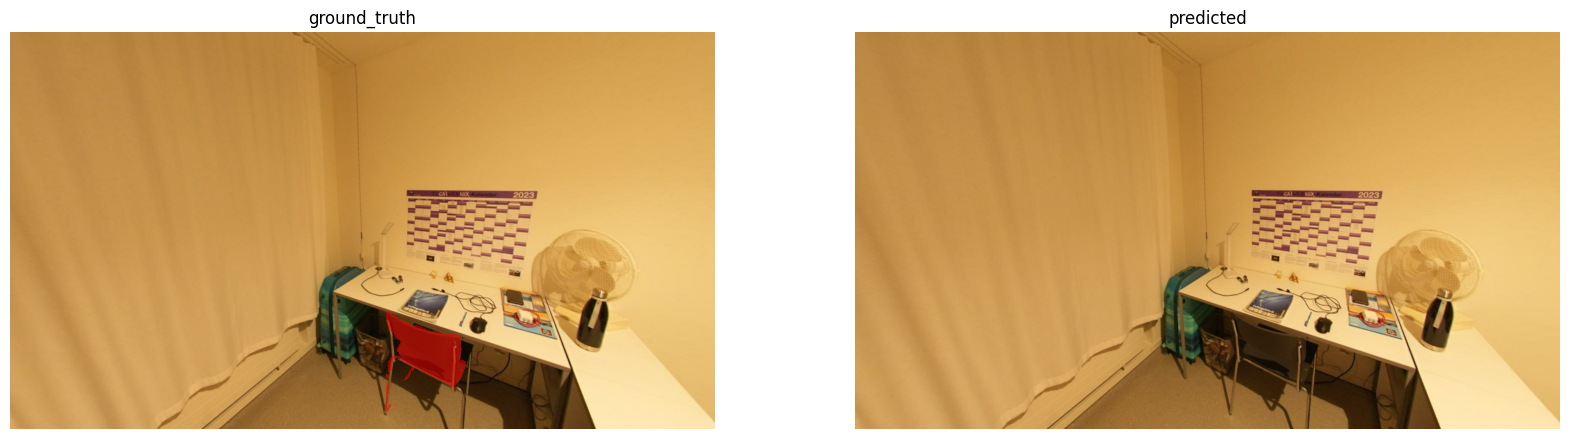

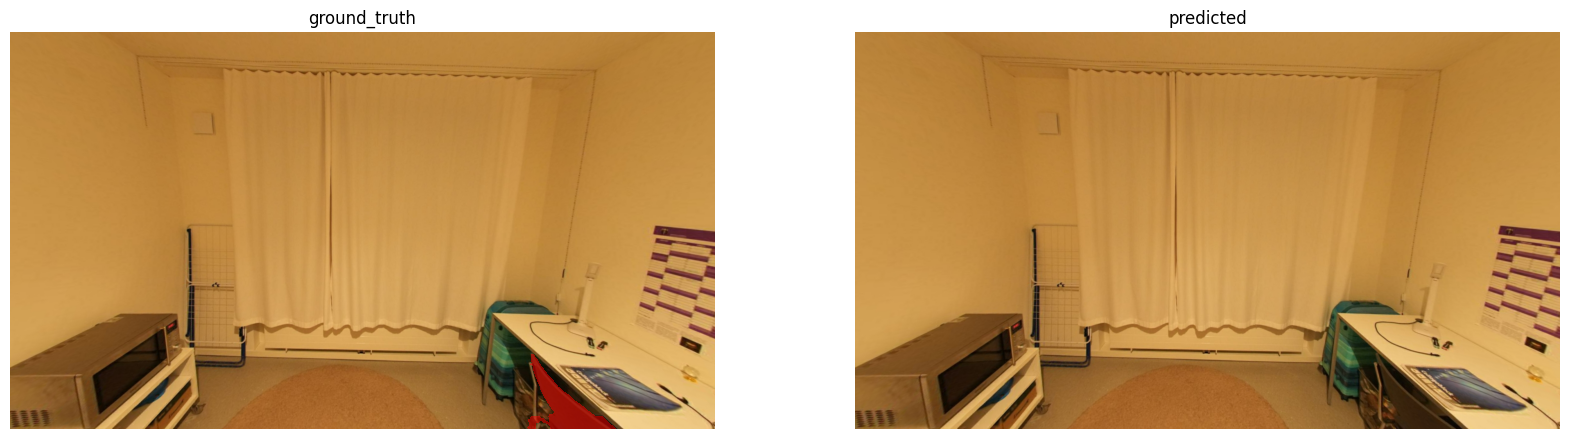

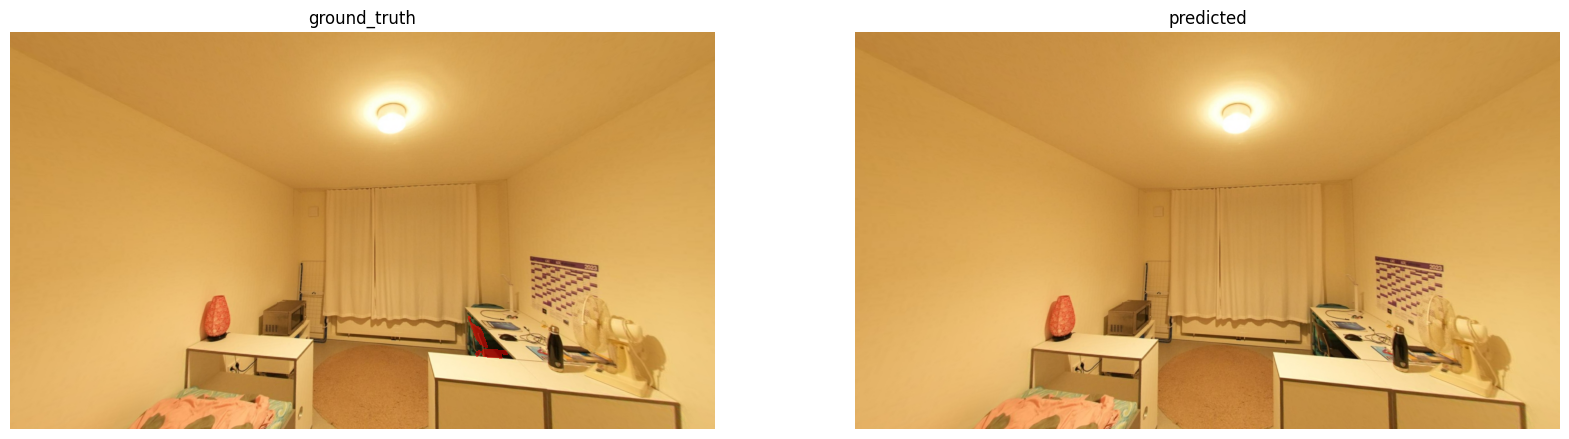

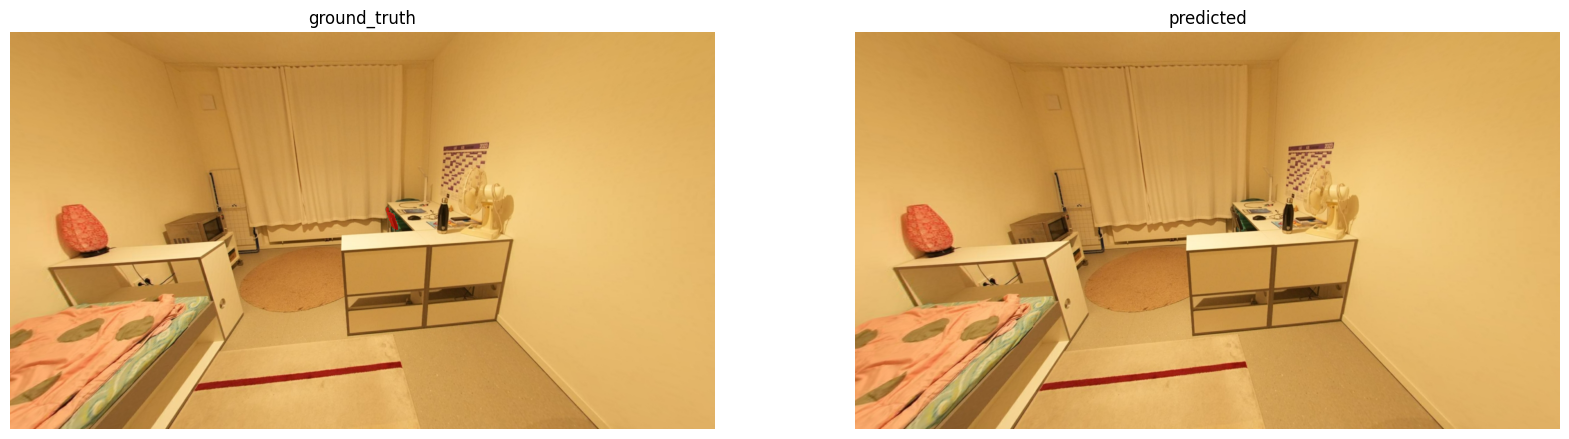

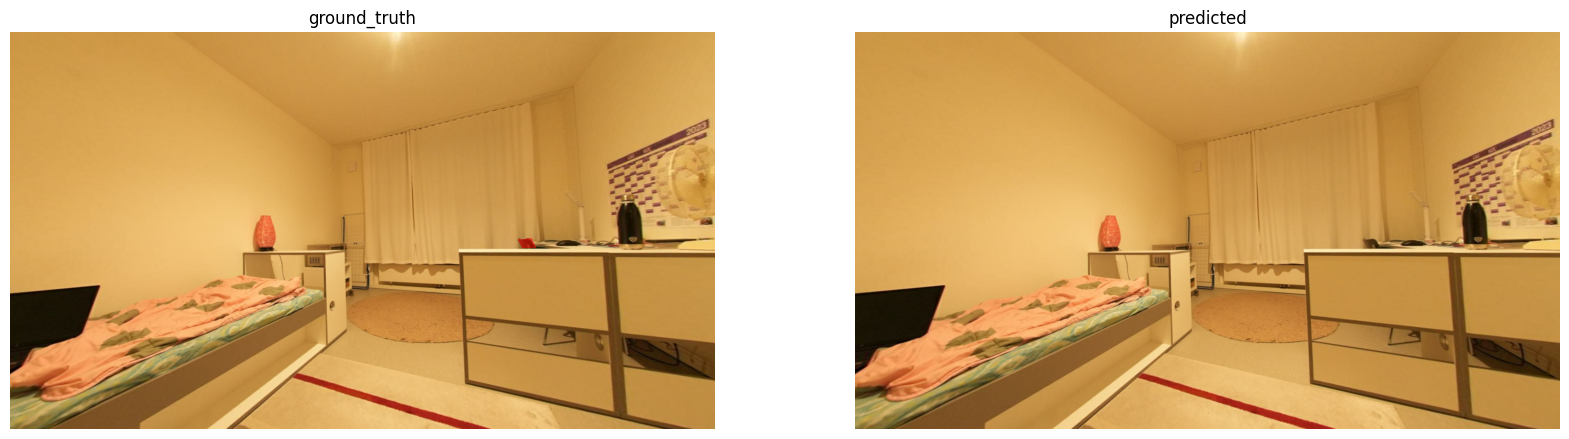

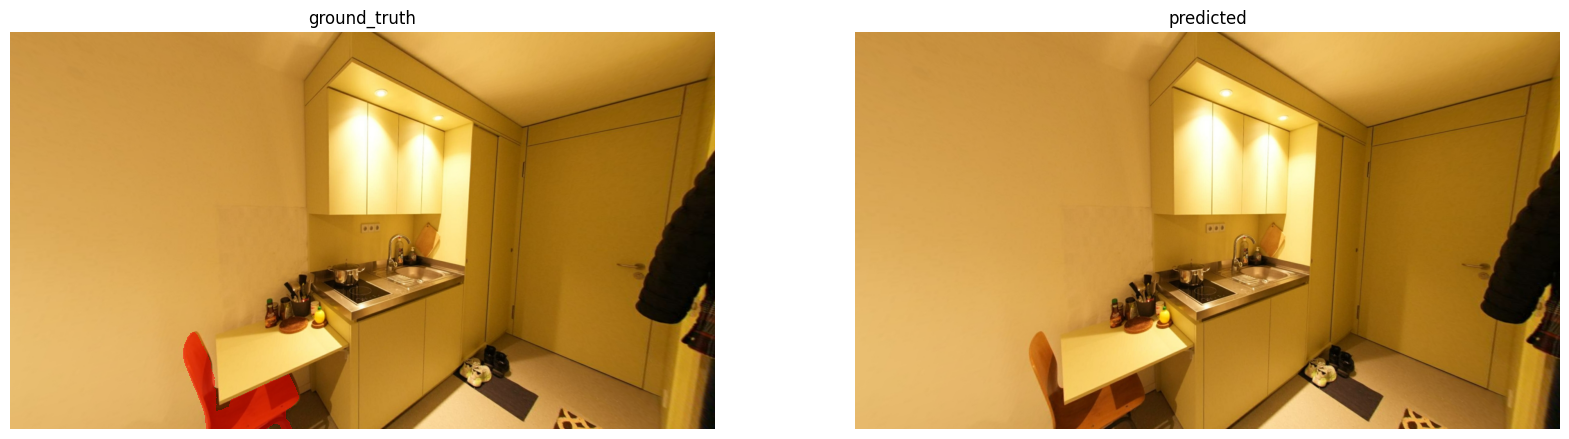

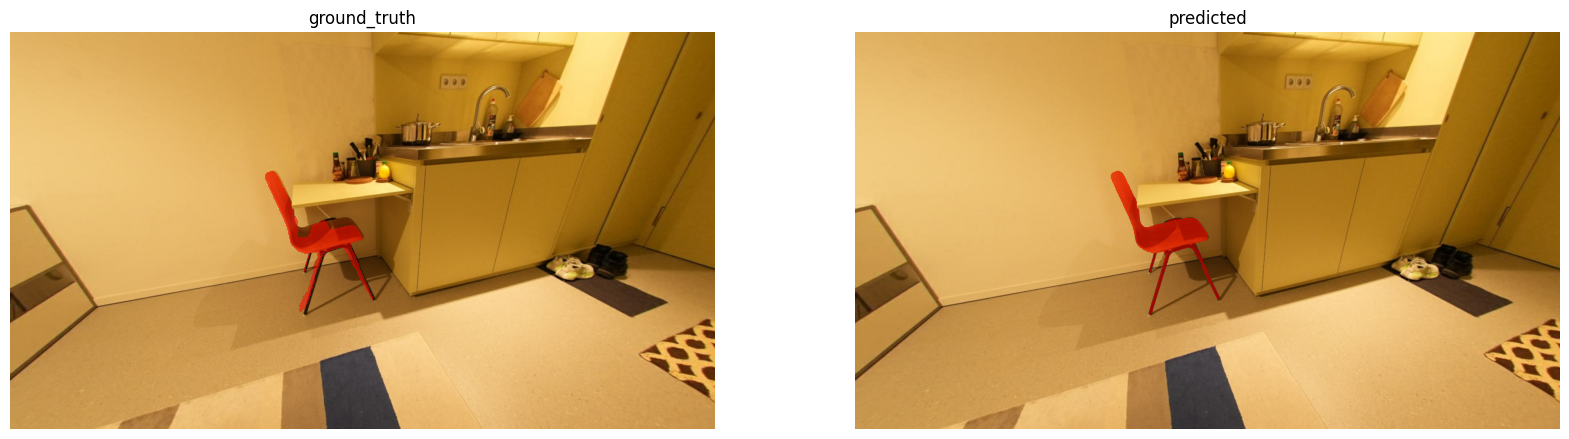

In [342]:
cmap2 = matplotlib.colors.ListedColormap(['none', 'red'])
for i in range(len(css)):
    cs = css[i]
    gt = gt_arr[i]
    segm = segm_arr[i]
    image = img_arr[i]
    best_segm = segm[cs > t_best]
    chair_mask =(gt==8)
    if not chair_mask.any():
        continue
    pred_mask = best_segm.any(axis=0)
    
    h, w = chair_mask.shape[-2:]
    mask_image = chair_mask.reshape(h, w)
    fig, ax = plt.subplots(1, 2, figsize=(20, 40))
    ax[0].imshow(image)
    ax[0].imshow(mask_image, alpha=0.5, cmap=cmap2)

    ax[1].imshow(image)
    ax[1].imshow(pred_mask, alpha=0.5, cmap=cmap2)
    
    ax[1].axis('off')
    ax[0].axis('off')

    ax[0].set_title('ground_truth')
    ax[1].set_title('predicted')
    plt.show()

There are some examples where no chair is detected. The reason is that a lot of images really dont contain chairs and then why IoU is high. (Recall that we set IoU to one in these cases)

Lets check IoU for images that contain chair:

100%|████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.81it/s]


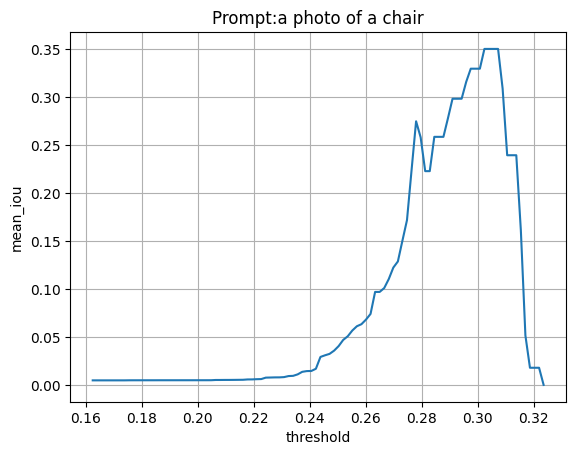

100%|████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.67it/s]


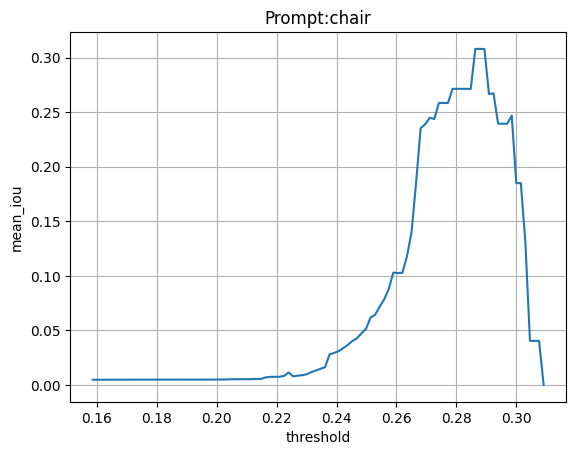

100%|████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  4.00it/s]


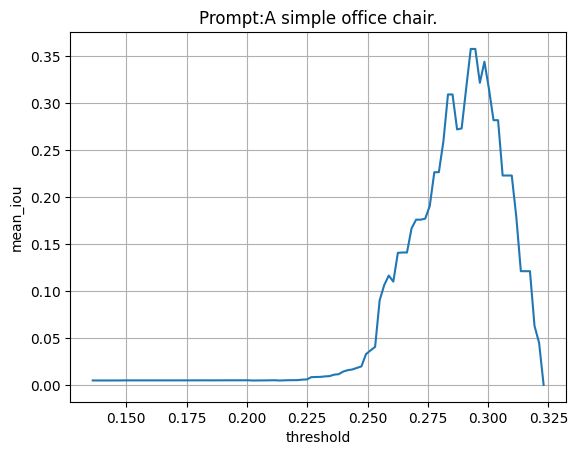

100%|████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]


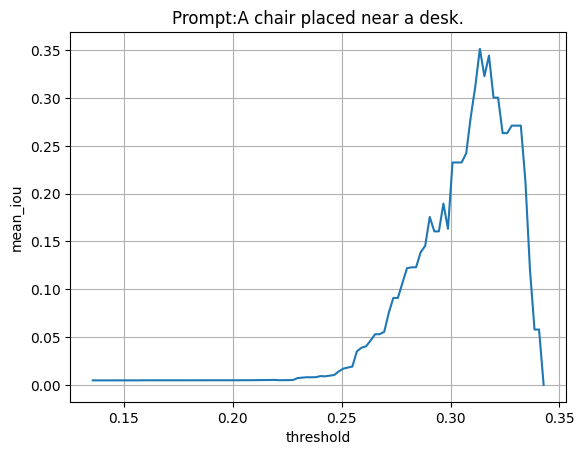

In [322]:
prompts = ["a photo of a chair", "chair", "A simple office chair.", "A chair placed near a desk."]
dct_new = {}
for p in prompts:
    best_t, best_iou = pipeline(dataset, clip, processor, mask_generator, prompt=p, is_one=False)
    dct_new[p] = [best_t, best_iou]

In [343]:
df_new = pd.DataFrame(dct_new, index=['best_threshold', 'best_iou'])

In [344]:
df_new

a photo of a chair     chair  A simple office chair.  \
best_threshold            0.302371  0.286279                0.292795   
best_iou                  0.349957  0.307926                0.357761   

                A chair placed near a desk.  
best_threshold                     0.313446  
best_iou                           0.351306

In [345]:
a, b = df_new.to_numpy()[0], df_new.to_numpy()[1]

In [346]:
t_best_new = a[np.argmax(b)]
t_best_new

0.2927945488029056

In [347]:
t_best_new - t_best

0.0

As we can see there is no difference beetween how to calculate IoU.